# Using ArchGDAL to read and write Rasters

This notebook is all about reading displaying and writting rasters using GDAL in Julia 1.1.0
I am primarily using ArchGDAL, which is available from here https://github.com/yeesian/ArchGDAL.jl please do visit this page. Please see the blog post associated to this series for further information and background.

If you are familiar with GDAL and Rasterio within Python then this should all be similar. ArchGDAL aims to build on top of GDAL providing a high level API

First off lets take a look at GDAL.jl

In [1]:
using GDAL
GDAL.allregister()
dataset = GDAL.open("Isle_wight.tif", GDAL.GA_ReadOnly)
print(dataset)

Ptr{GDAL.GDALDatasetH} @0x0000000009e20350

We can open the Isle_wight.tif in GDAL. By printing the dataset we can see that it is a GDAL object.
<br>This data is a Sentinel2a 3 band RGB true colour image</br>

We can access 1 band using the getrasterband command

In [2]:
band = GDAL.getrasterband(dataset, 1)
print(band)

Ptr{GDAL.GDALRasterBandH} @0x0000000015781e50

Check out more about the GDAL package here https://github.com/JuliaGeo/GDAL.jl for now we will move on onwards with ArchGDAL. First though lets view our raster like its a 'normal' ie non geotiff image

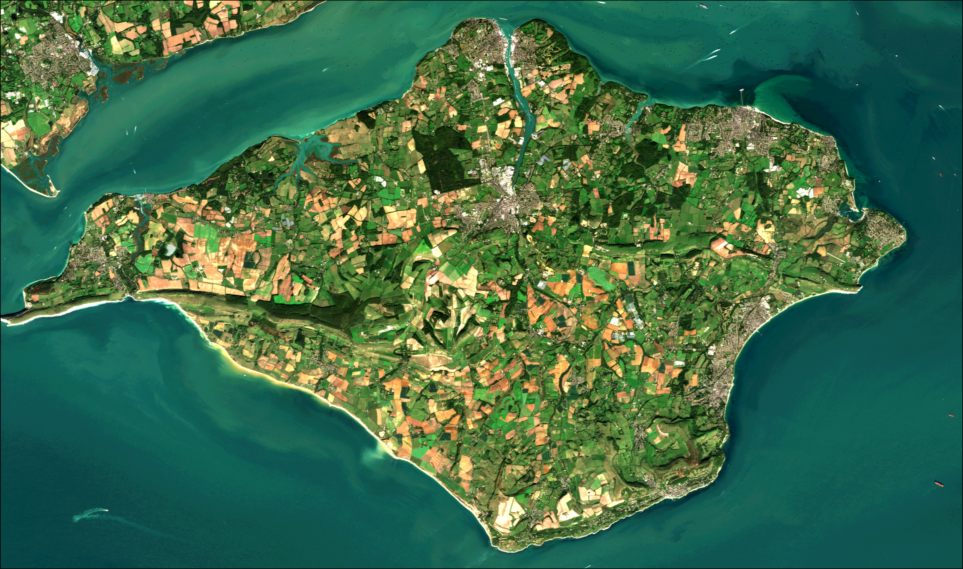

In [3]:
using ImageView, Images
img = load("Isle_wight.tif")

This image is a 99% clip stretch that I created in rasterio in Python. Julia displays it as if it is a photograph. Have a look at the image and imageviewer packages

# Rasters are just arrays

look what happens when I access a column and row in Julia

In [4]:
img[350,225] ## column and row

In [5]:
img[1000,1] 

Get some information about the array, we will use this knowledge later. Lets print the file size, the type and the shape of the data

In [6]:
sizeof(img)

26221152

In [7]:
typeof(img)

Array{RGB{Normed{UInt8,8}},2}

In [8]:
size(img) ## this is the equivalent of array.shape() in Python

(2272, 3847)

Now that we have introduced some of the basics and got a feel for Julia's capability lets use ArchGDAL to access this image. Adpated from http://yeesian.com/ArchGDAL.jl/latest/rasters.html

In [9]:
using ArchGDAL
# http://yeesian.com/ArchGDAL.jl/latest/rasters.html
ArchGDAL.registerdrivers() do
ArchGDAL.read("Isle_wight.tif") do dataset
    typeof(dataset)
    end
end

ArchGDAL.Dataset

Now that we know how to read the data in as a ArchGDAL dataset lets read one band in and plot it. Using the colors package to mimic Python matplotlib.pylot imshow()

Array{UInt8,2}
Array{Float64,2}


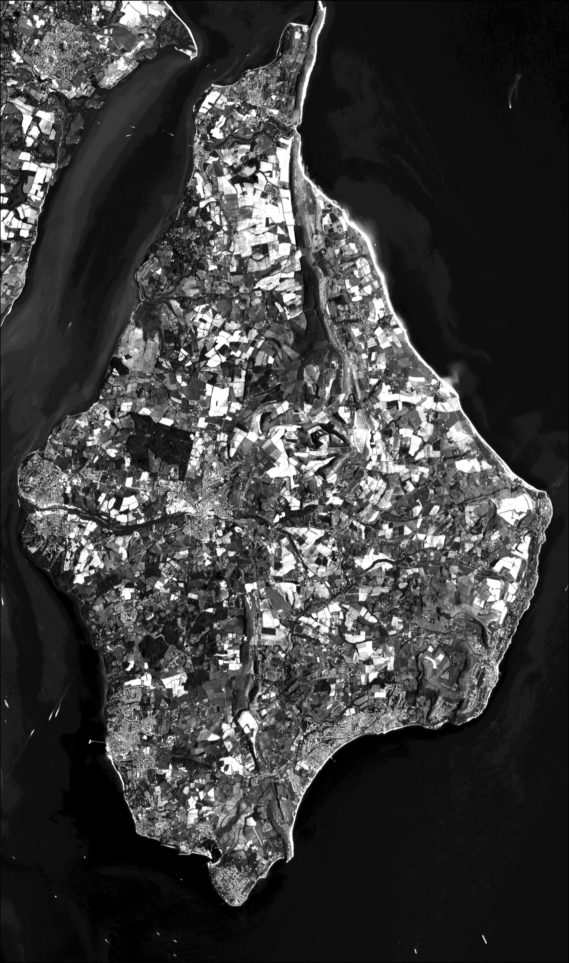

In [10]:
using Colors
ArchGDAL.registerdrivers() do
ArchGDAL.read("Isle_wight.tif") do dataset
    band = ArchGDAL.getband(dataset,1)
    band_array = ArchGDAL.read(band) # read into array
    println(typeof(band_array))
    ## we need to convert to a float scaled between 0 - 1 to display (input in UInt8)    
    band_array_float = band_array / 255
    println(typeof(band_array_float))
    imgg = Gray.(band_array_float)
    end
end

Whoops! that is not how we want to display the image. I don't know at this point if the reason for this is due to the way Julia arrays are plot in the colors package, but we need to do something about this. In Python we would use NumPy transpose in Julia we call permutedims

Check out https://github.com/JuliaLang/julia/blob/master/base/permuteddimsarray.jl and of more value https://docs.julialang.org/en/v0.6/stdlib/arrays/

Array{Float64,2}


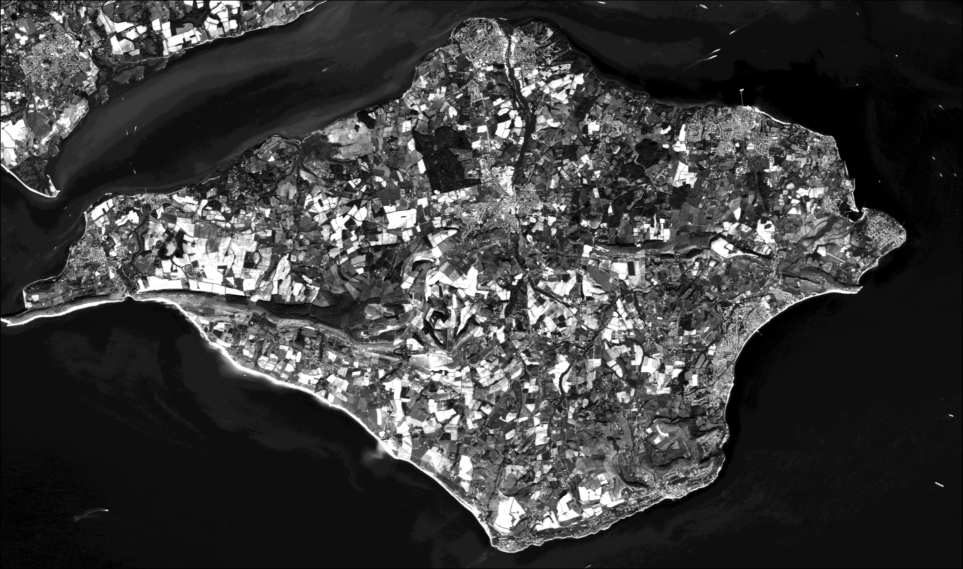

In [11]:
using Colors
ArchGDAL.registerdrivers() do
ArchGDAL.read("Isle_wight.tif") do dataset
    band = ArchGDAL.getband(dataset,1)
    new = ArchGDAL.read(band) # read into array
    band = ArchGDAL.getband(dataset,1)
    band_array = ArchGDAL.read(band) # read into array

    ## transpose    
    band_array_adjust = permutedims(band_array, (2,1))
        
    ## we need to convert to a float scaled between 0 - 1 to display (input in UInt8)    
    band_array_float = band_array_adjust / 255
    println(typeof(band_array_float))
    imgg = Gray.(band_array_float)
        
    end
end

Great! we have a geotiff single band image plotted in a grey scale

Now that we can walk lets run and load it as a RGB image

I am going to break it down so hopefully it will make sense. Below is NOT recommended as its repeating code, but done for illustrative purposes

Everything is similar to before apart from these lines
<br></br>
<br>total = cat(dims=3, b1_n, b2_n, b3_n)</br>
  <br>  imgc2 = colorview(RGB, permuteddimsview(total, (3,1,2)))</br>

reference : https://discourse.julialang.org/t/how-to-convert-a-matrix-to-an-rgb-image-using-images-jl/7265/9

What is going on with these lines? well If you are familiar with python then the first attacks like np.stack. cat() and then parse 3 dimensions and then the arrays (bands in our case). The sceond line tells Julia it is total is a colour image and points the order needed to plot

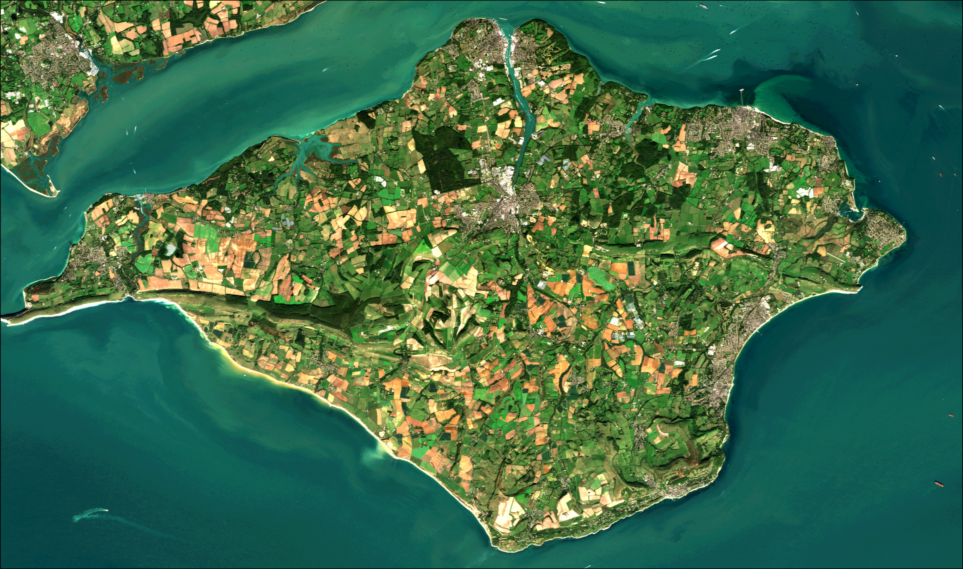

In [12]:
using Colors
ArchGDAL.registerdrivers() do
ArchGDAL.read("Isle_wight.tif") do dataset
    band1 = ArchGDAL.getband(dataset,1)
    band2 = ArchGDAL.getband(dataset,2)
    band3 = ArchGDAL.getband(dataset,3)
    b1 = ArchGDAL.read(band1)/255 # read into array
    b2 = ArchGDAL.read(band2)/255
    b3 = ArchGDAL.read(band3)/255
    b1_n = permutedims(b1, (2,1))
    b2_n = permutedims(b2, (2,1))
    b3_n = permutedims(b3, (2,1))
    total = cat(dims=3, b1_n, b2_n, b3_n)
    typeof(total)
    imgc2 = colorview(RGB, permuteddimsview(total, (3,1,2)))

    end
end

Lets refactor to something with less lines and hopefully more useful. If you are note familiar with for loops in Julia the first cell below shows a basic example

In [13]:
## learning about for loops
x = 1,2,3
println(length(x))


for i = 1:length(x)
  println(x[i])
end

3
1
2
3


We can use properties of the raster to create an empty array and then append data into that array. The empty array is below called m. It is a float 64 dataset with undefined values, withe the dimensions of height, width and number of raster bands (number_raster)

Now that we have the empty array we use a for loop to iterate over each band and append to the array, but prior to that we convert to the input to a float and transpose as before. finally we assign the value to the relevant dimension (i). m[;,;,i]

3847
2272


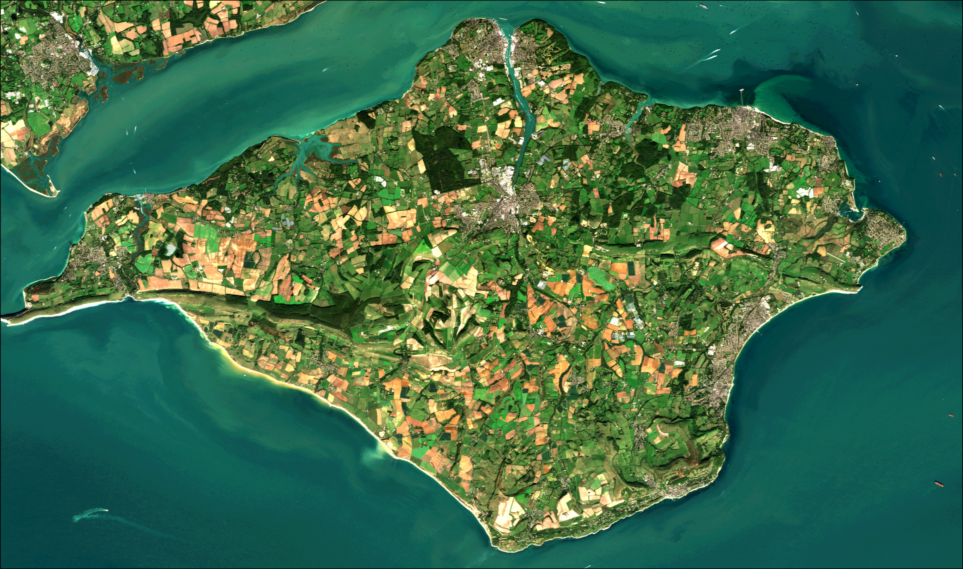

In [14]:
using Colors
ArchGDAL.registerdrivers() do    
ArchGDAL.read("isle_wight.tif") do dataset
    #println(dataset)
    number_rasters = (ArchGDAL.nraster(dataset))
    width = ArchGDAL.width(dataset)
    height = ArchGDAL.height(dataset)
    println(width)
    println(height)
    m = Array{Float64}(undef, height, width, number_rasters)

    
    for i = 1:number_rasters
      band = ArchGDAL.getband(dataset,i)
        b = ArchGDAL.read(band)/255 
        b_n = permutedims(b, (2,1)) 
        m[:, :, i] = b_n
    end
    typeof(m)
    imgc2 = colorview(RGB, permuteddimsview(m, (3,1,2)))

    end
end

Finally lets write out a single band of raster data using Julia

In this final example I will need to assign the projection to the output. Otherwise you just get an image. This is a Geospatial tutorial after all

reference https://github.com/yeesian/ArchGDAL.jl/blob/master/test/test_ospy_examples.jl

In [15]:
using ArchGDAL; const AG = ArchGDAL ## make AG the shortcut to ArchGDAL, by doing this I call AG. rather than ArchGDAL.
AG.registerdrivers() do
    AG.read("Isle_wight.tif") do dataset
    band1 = ArchGDAL.getband(dataset,1) ## read in 1 band
    ref = AG.getproj(dataset) ## get the project
    new1 = ArchGDAL.read(band1) ## get the data into an array
    geotransform = AG.getgeotransform(dataset) ## get the geotransformation propoerties
    println(geotransform)
    println("projection:")
    println(ref)
        
    raster = AG.unsafe_create(
        "band1.tif",
        AG.getdriver("GTiff"),
        width = ArchGDAL.width(dataset),
        height = ArchGDAL.height(dataset),
        nbands = 1,
        dtype = UInt8
    )
    ## assign the projection and transformation parameters
    AG.setgeotransform!(raster, geotransform)
    AG.setproj!(raster, ref)
    
    ## write the raster    
    AG.write!(
        raster,
        new1,  # image to "burn" into the raster
        1,      # update band 1
    )
    AG.destroy(raster)
    end
end

[600140.0, 10.0, 0.0, 5.626e6, 0.0, -10.0]
projection:
PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


Ptr{Nothing} @0x0000000000000000

lets read the image back in to check (but probably best in a GIS - use QGIS 3!)

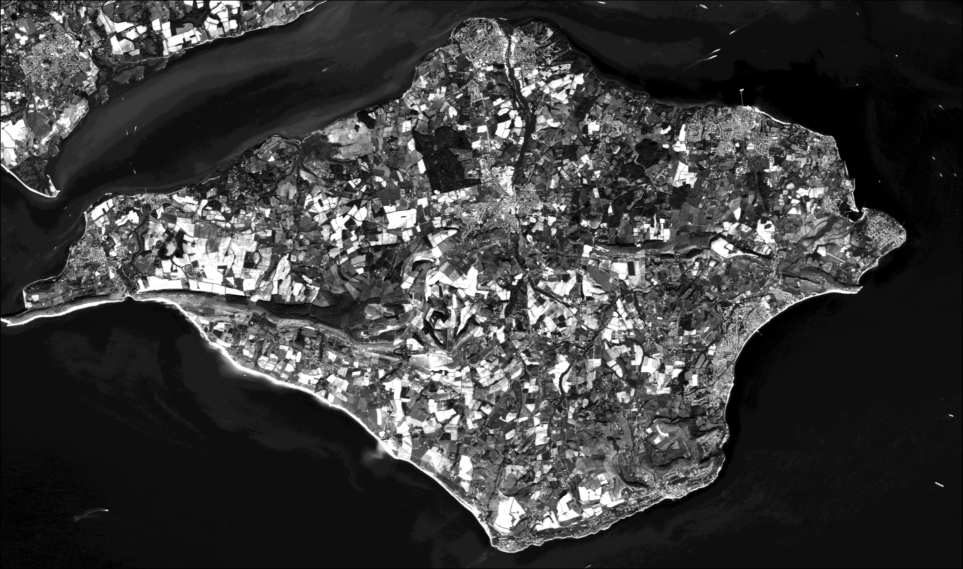

In [16]:
using ArchGDAL; const AG = ArchGDAL
using Colors
AG.registerdrivers() do
AG.read("band1.tif") do dataset
    band = AG.getband(dataset,1)
    new = AG.read(band) # read into array
    band = AG.getband(dataset,1)
    band_array = AG.read(band) # read into array

    ## transpose    
    band_array_adjust = permutedims(band_array, (2,1))
        
    ## we need to convert to a float scaled between 0 - 1 to display (input in UInt8)    
    band_array_float = band_array_adjust / 255

    imgg = Gray.(band_array_float)
        
    end
end